# Importing Dependencies



In [1]:
import re
import numpy as np
import pandas as pd

import tweepy

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

## Importing Dataset

In [2]:
dataset_columns = ["sentiment" , "id" , "time" , "flag" , "user" , "text" ]
dataset_coding = "ISO-8859-1"
dataset = pd.read_csv("data set/training.1600000.processed.noemoticon.csv", names = dataset_columns , encoding = dataset_coding )

In [3]:
dataset.head()

,sentiment,id,time,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
dataset["sentiment"].unique()

array([0, 4])

In [7]:
dataset["sentiment"].nunique()

2

In [8]:
dataset["sentiment"].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [9]:
dataset.isnull().sum()

sentiment    0
id           0
time         0
flag         0
user         0
text         0
dtype: int64

## Preprocessing / Cleaning Text

In [10]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')


[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


In [33]:
def preprocess(tweet , stem = True):
    processedText = []
    
    urlPattern =  r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphanumericPattern = r'\w*\d\w*'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    punc = r'[^\w\s]'
    
    #tweet = tweet.lower()
    tweet = re.sub(urlPattern , '' , tweet)
    tweet = re.sub(userPattern , '' , tweet)
    tweet = re.sub(alphanumericPattern , '' , tweet)
    tweet = re.sub(sequencePattern , seqReplacePattern , tweet)
    tweet = re.sub(punc,"",tweet)
    
    tweet = tweet.split()   
    ps = PorterStemmer()
    
    all_stopwords = stopwords.words('english')
  
    
    for word in tweet:
            if word not in (all_stopwords):
                if stem:
                    processedText.append(ps.stem(word))
                else:
                    processedText.append(word)
                
    return " ".join(processedText)
    
        
   

      

In [12]:
cleared_dataset = dataset.sample(frac=1).reset_index(drop=True)
cleared_dataset = cleared_dataset.iloc[0:1000000]
cleared_dataset.info()
cleared_dataset["sentiment"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1000000 non-null  int64 
 1   id         1000000 non-null  int64 
 2   time       1000000 non-null  object
 3   flag       1000000 non-null  object
 4   user       1000000 non-null  object
 5   text       1000000 non-null  object
dtypes: int64(2), object(4)
memory usage: 45.8+ MB


4    500411
0    499589
Name: sentiment, dtype: int64

In [13]:
import time
start_time = time.time()
cleared_dataset = cleared_dataset.drop(cleared_dataset.index[0]).reset_index()
cleared_dataset = cleared_dataset.drop(['time','flag','user','id','index'],axis=1)
cleared_dataset["text"] = cleared_dataset["text"].apply(preprocess)
print("--- %s seconds ---" % (time.time() - start_time))
X = cleared_dataset['text']
print(X)

--- 262.65010476112366 seconds ---
0                                          friend hell yeah
1                    shall watch beeaach soon children leav
2         im back relax weekend manag think workrel thin...
3                                      back work coupl hour
4                   haha your cool till juli gonna awesomel
                                ...                        
999994    morn morn anoth gorgeou day gonna work homewor...
999995                                    love wake sunshin
999996       haha total forgot rico tubb guest mix week nsb
999997    wow im realli go watch pcd wednesday bought ti...
999998      rush sushi tei ps lunch appoint gonna great one
Name: text, Length: 999999, dtype: object


In [14]:
cleared_dataset

,sentiment,text
0,4,friend hell yeah
1,4,shall watch beeaach soon children leav
2,4,im back relax weekend manag think workrel thin...
3,0,back work coupl hour
4,4,haha your cool till juli gonna awesomel
...,...,...
999994,4,morn morn anoth gorgeou day gonna work homewor...
999995,4,love wake sunshin
999996,4,haha total forgot rico tubb guest mix week nsb
999997,4,wow im realli go watch pcd wednesday bought ti...


## Analysing Data

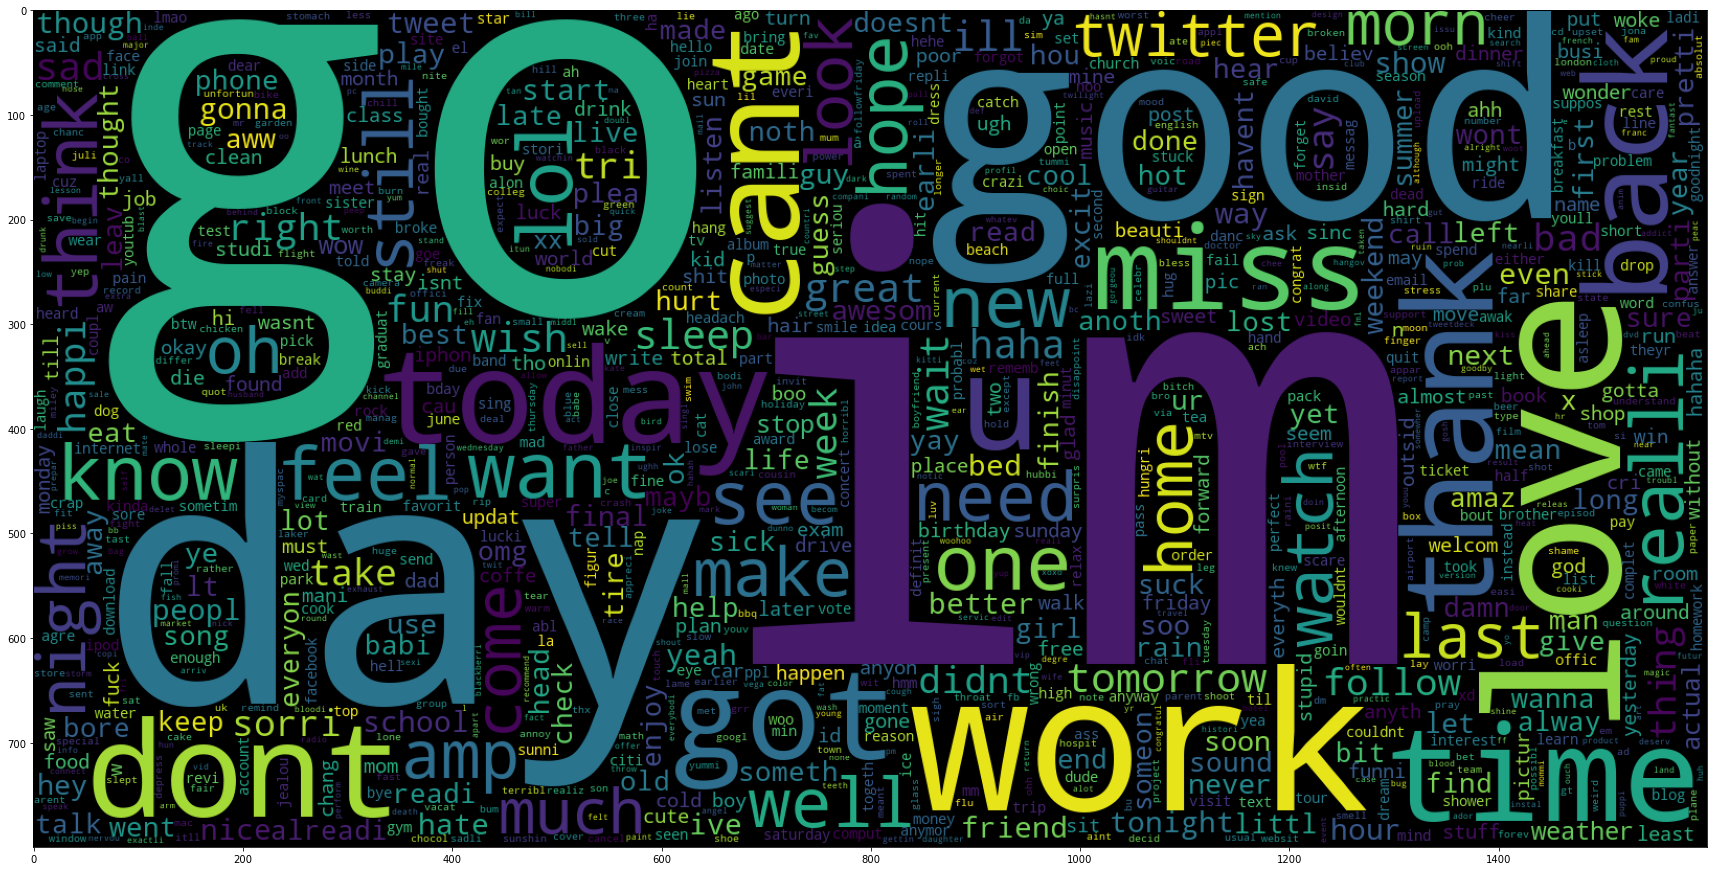

In [15]:
positive_tweet = cleared_dataset["text"][800000:]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, positive_tweet)))
plt.imshow(wc)

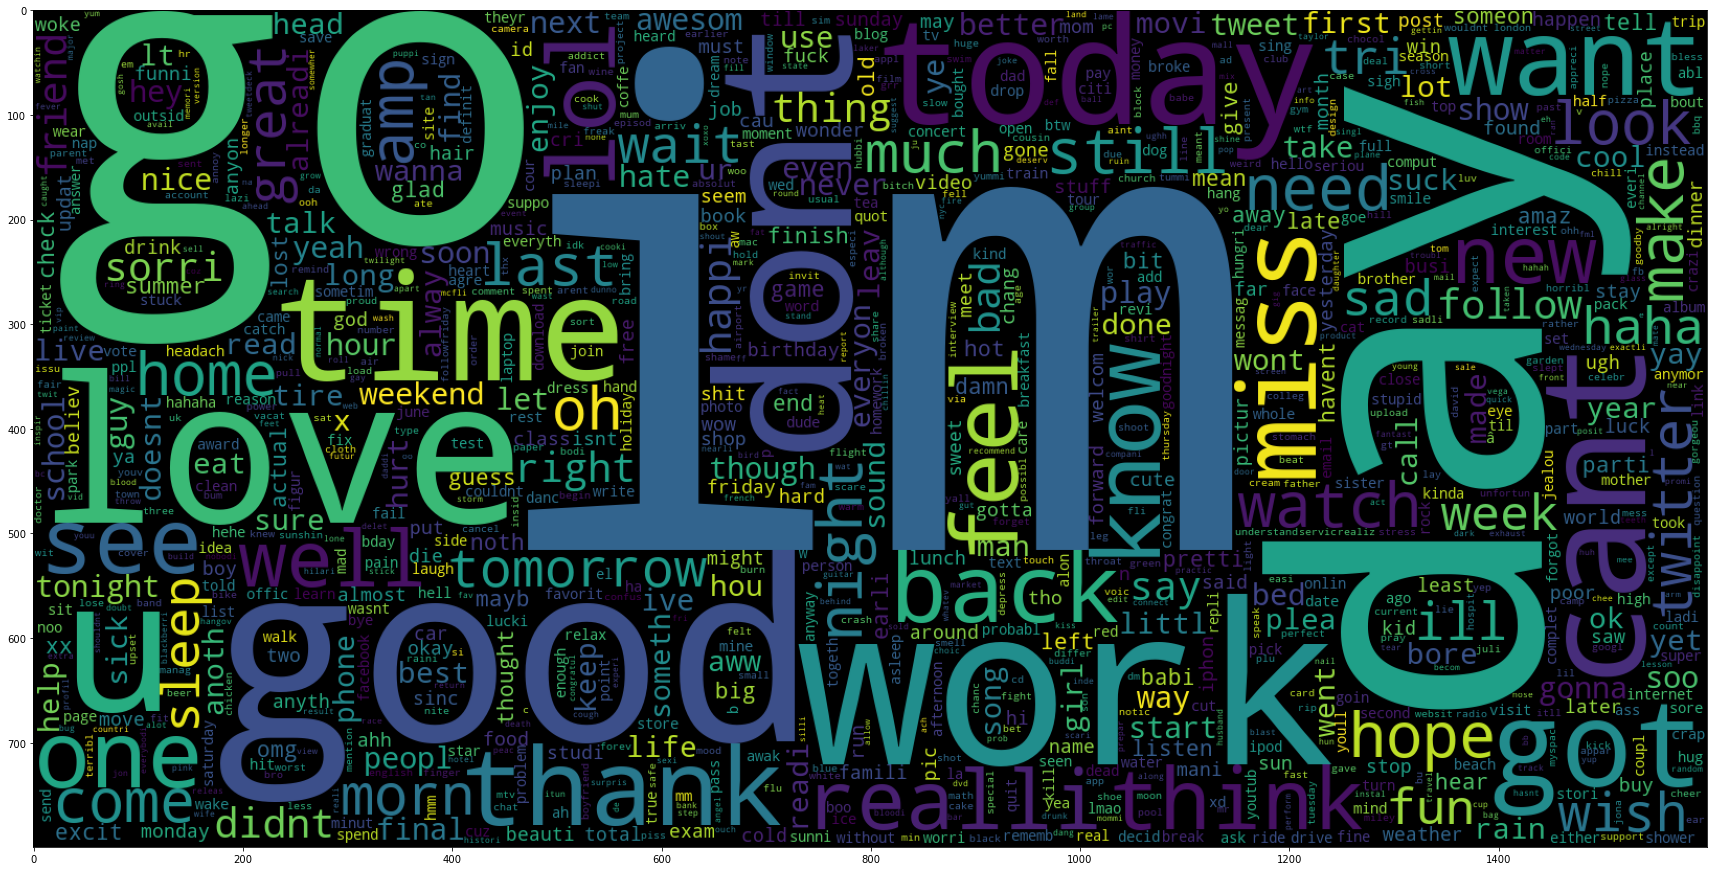

In [16]:
negative_tweet = cleared_dataset["text"][:800000]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, negative_tweet)))
plt.imshow(wc)

## Splitting Dataset

In [17]:
y = cleared_dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.30, random_state = 10)

## TF - IDF Vectorizer

In [18]:
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.90, min_df=2, max_features = 500000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
tfidf_tokens = vectorizer.get_feature_names()
print("Number of feature_words = ", len(tfidf_tokens))
print(tfidf_tokens[1:2000])


Number of feature_words =  448945
['__ dont', '__ fill', '__ fuck', '__ get', '__ hope', '__ ill', '__ look', '__ love', '__ miss', '__ oh', '__ suck', '__ take', '__ thank', '__ wish', '__i', '__lt', '__quot', '__x', '_bam_', '_girl', '_hate_', '_i_', '_lt', '_myanalt', '_quot', '_really_', '_those_', '_was_', 'a_list', 'aa', 'aa batteri', 'aa bore', 'aa cant', 'aa come', 'aa dad', 'aa dont', 'aa fuck', 'aa gaya', 'aa get', 'aa hahaha', 'aa hate', 'aa lot', 'aa love', 'aa man', 'aa miss', 'aa new', 'aa rescu', 'aa see', 'aa want', 'aa xd', 'aac', 'aachen', 'aackk', 'aaf', 'aag', 'aag ago', 'aaggeess', 'aaggh', 'aagghh', 'aagh', 'aagiu', 'aah', 'aah bore', 'aah breakfast', 'aah cant', 'aah damn', 'aah demi', 'aah dont', 'aah feel', 'aah go', 'aah good', 'aah gotta', 'aah great', 'aah guy', 'aah hate', 'aah home', 'aah im', 'aah keep', 'aah last', 'aah lol', 'aah love', 'aah male', 'aah miss', 'aah much', 'aah nice', 'aah ok', 'aah oke', 'aah one', 'aah pictur', 'aah rock', 'aah save', 

In [19]:
X_test  = vectorizer.transform(X_test)

## Scaling

In [20]:
x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
X_test = (X_test - x_min)/x_max


## Model Evaluation

In [21]:

def model(model):
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.values 
    y_test_ = pd.Series(y_test) 
    y_test_ = y_test_.values 
    #print("Comparison:")
    #result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test_.reshape(len(y_test_),1)),1)
    #print(result[1:500])
    
    c_matrix = confusion_matrix(y_test_, y_pred)
    print("Confusion Matrix = \n",c_matrix)
    print("Accuracy Score = ",accuracy_score(y_test_, y_pred))
    print("Train Score = ",model.score(X_train, y_train))
    print("Test Score = ",model.score(X_test, y_test))
    
    
    
    categories = ['Negative','Positive']
    prediction = ['True Negative','False Positive', 'False Negative','True Positive']
    percentage = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

    labels = [f'{m}\n{n}' for m, n in zip(prediction,percentage)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix,cmap = 'Blues' , fmt = '',annot = labels, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    
    

## Logistic Regression

Confusion Matrix = 
 [[116761  33205]
 [ 29246 120788]]
Accuracy Score =  0.79183
Train Score =  0.8637669482384975
Test Score =  0.79183
--- 13.756625175476074 seconds ---


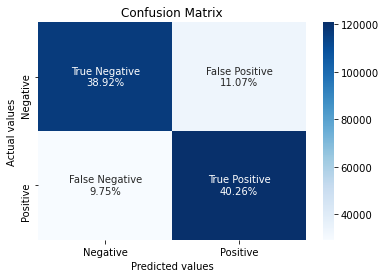

In [22]:
import time
start_time = time.time()
logistic_reg = LogisticRegression(solver = 'sag',C = 2, max_iter = 1500)
logistic_reg.fit(X_train, y_train) 
model(logistic_reg)
print("--- %s seconds ---" % (time.time() - start_time))

## Bernoulli Naive Bayes 

Confusion Matrix = 
 [[111658  38308]
 [ 29070 120964]]
Accuracy Score =  0.7754066666666667
Train Score =  0.841546916495595
Test Score =  0.7754066666666667
--- 0.8444709777832031 seconds ---


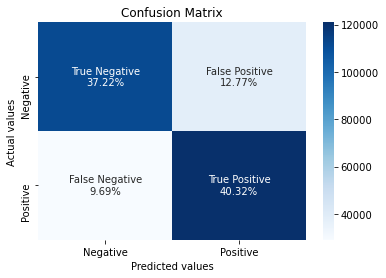

In [23]:
start_time = time.time()
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train) 
model(naive_bayes)
print("--- %s seconds ---" % (time.time() - start_time))

## SVM


Confusion Matrix = 
 [[115193  34773]
 [ 30929 119105]]
Accuracy Score =  0.7809933333333333
Train Score =  0.9124684463834948
Test Score =  0.7809933333333333


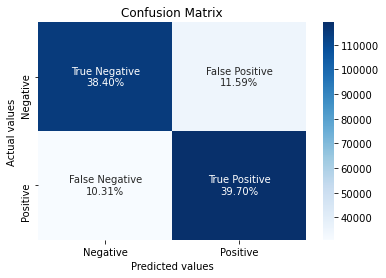

In [50]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


svm = LinearSVC()
svm_model = CalibratedClassifierCV(svm) 
svm_model.fit(X_train, y_train)
model(svm_model)

##scikit-learn provides (CalibratedClassifierCV) which can be used to solve this problem: it allows to add probability output 
##to LinearSVC or any other classifier which implements decision_function method:

### Predict {Sentiment,Time,Probability}

In [52]:
def predict(model,text):
    start_time = time.time()
    sentiment=0
    sentiment_prob=[[]]
    textdata = vectorizer.transform([preprocess(text)])
    sentiment = model.predict(textdata)
    sentiment_prob = model.predict_proba(textdata)   
    prob = ('%.2f'%max(max(sentiment_prob*100)))
    timer = "%.2f seconds" % (time.time() - start_time)
    return sentiment[0],timer,prob      

### Sentiment Using API

In [28]:
config = pd.read_csv("data set/config.csv")

twitterApiKey = str(config['twitterApiKey'][0])
twitterApiSecret = str(config['twitterApiSecret'][0])
twitterApiAccessToken = str(config['twitterApiAccessToken'][0])
twitterApiAccessTokenSecret = str(config['twitterApiAccessTokenSecret'][0])

# Authenticate
auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
twetterApi = tweepy.API(auth, wait_on_rate_limit = True)


twitterAccount = "sunnyleone"

tweets = tweepy.Cursor(twetterApi.user_timeline, 
                        screen_name=twitterAccount, 
                        count=None,
                        since_id=None,
                        max_id=None,
                        trim_user=True,
                        exclude_replies=True,
                        contributor_details=False,
                        include_entities=False
                        ).items(50);
print(tweets)

tweet_DataBase = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweet'])

TweepError: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/user_timeline.json?screen_name=sunnyleone&trim_user=True&exclude_replies=True&contributor_details=False&include_entities=False (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1703fa5820>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
### DataFrame for the sentiment of the user

for model in [logistic_reg,naive_bayes,svm_model]:
        prediction=[]
        for tweets in tweet_DataBase["Tweet"]:
            prediction.append(predict(model,tweets))
        tweet_DataBase[model]=prediction
tweet_DataBase.columns=["Tweets","log_reg","naive","svm"]

In [ ]:
def predict_text(text,model):
    start_time = time.time()
    sentiment=0
    sentiment_prob=[[]]
    textdata = vectorizer.transform([preprocess(text)])
    if model=="logistic_reg":
        sentiment = logistic_reg.predict(textdata)
        sentiment_prob = logistic_reg.predict_proba(textdata)
    elif model=="naive_bayes":
        sentiment = naive_bayes.predict(textdata)
        sentiment_prob = naive_bayes.predict_proba(textdata)
    elif model=="svm_model":
        sentiment = svm_model.predict(textdata)
        sentiment_prob = predict_prob_svc(textdata)
    print(sentiment_prob)
    print(type(sentiment_prob))
    prob = ('%.2f'%max(max(sentiment_prob*100)))
    timer = "%.2f seconds" % (time.time() - start_time)
    return sentiment[0],timer,prob

In [54]:
predict(svm_model,"i love to see you")

NameError: name 'sm' is not defined